In [1]:
import os, glob, json, csv, subprocess, sys, re
from git import *
from subprocess import Popen, PIPE
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as ply
import plotly
from plotly.offline import plot, init_notebook_mode, iplot

%matplotlib inline

In [2]:
userhome = os.path.expanduser('~')

# Create directory list

In [3]:
dir_list = glob.glob(userhome + r'/local-repo/*')
print ("Found " + str(len(dir_list)) + " dirs")

Found 6 dirs


In [4]:
with open ("dir_list.txt", mode="wt", encoding="utf-8") as myfile:
    myfile.write('\n'.join(dir_list))
print ("File dir_list.txt has been created")

File dir_list.txt has been created


# Load directory list from file 

In [5]:
txt_file = open("dir_list.txt", "r")
dir_list = txt_file.read().split('\n')
print ("Found " + str(len(dir_list)) + " dirs")

Found 6 dirs


# Defining function to extract commit log

In [6]:
def execute_shell_command(cmd, work_dir):
    """Executes a shell command in a subprocess, waiting until it has completed.
 
    :param cmd: Command to execute.
    :param work_dir: Working directory path.
    """
    pipe = subprocess.Popen(cmd, shell=True, cwd=work_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (out, error) = pipe.communicate()
    return out, error
    pipe.wait()

Defining Repository

In [7]:
repository  = os.path.dirname(userhome + r'/local-repo/') 

List of git command

In [8]:
cmd = ['git log -w --unified=5 | wc -l', 'git log --unified=5 | wc -l', 
       'git log -U0 -w | wc -l', 'git log -U0 | wc -l', 
       'git log -w --patch | wc -l', 'git log --patch | wc -l']

In [9]:
result = []
for i in range(0,len(cmd)):
    sys.stdout.write("\rApplying git command = %i" % (i+1))
    sys.stdout.flush()
    result.append(int(str(execute_shell_command(cmd[i], repository)).replace("b",'').replace("'",'').
                      replace(' ','').replace("\\n,",'').replace("(",'').replace(")",'')))

print ("\n")
x = len(result)
y = x
for item in result:
    print (cmd[x-y] , "\t\t = " , item)
    y = y-1

Applying git command = 6

git log -w --unified=5 | wc -l 		 =  4967
git log --unified=5 | wc -l 		 =  5037
git log -U0 -w | wc -l 		 =  4670
git log -U0 | wc -l 		 =  4733
git log -w --patch | wc -l 		 =  4876
git log --patch | wc -l 		 =  4946


# Extracting Commit ID

In [10]:
command = "git log --pretty='%H'"

In [11]:
com_ID = str(execute_shell_command(command, repository)).replace("b'",'').replace("'",'').replace('\\n',' ').replace("(",'').replace(")",'').replace(",",'').split(' ')

# Applying git diff commitID_1 commitID2 --shortstat

In [12]:
diff = []
for i in range(0, len(com_ID)-3):
    sys.stdout.write('\rExtracting diff = %i' % (i+1) + ' out of %i' % (len(com_ID)-3))
    sys.stdout.flush()
    diff_cmd = "git diff " + com_ID[i+1] + " " + com_ID[i] + " --shortstat"
    diff.append(str(execute_shell_command(diff_cmd, repository)).replace("b'",'').replace("'",'').replace("\\n",' ').replace("( ",'').replace(" )",''))

Extracting diff = 58 out of 58

In [13]:
for x in range(0,len(diff)):
    line = diff[x]
    if "deletion" not in diff[x]:
        index = line.find('(+)')
        diff[x] = line[:index] + ', 0 deletions(-) ,'
    if "insertion" not in diff[x]:
        index = diff[x].find(',')
        diff[x] = line[:index] + ', 0 insertions(+)' + line[index:]
    else:
        diff[x] = diff[x]

In [14]:
diff_metrics = []
for j in range(0,len(diff)):
    diff_metrics.append(re.findall(r'\d+', diff[j]))

for k in range(0, len(diff_metrics)):
    diff_metrics[k] = list(map(int, diff_metrics[k]))

In [15]:
with open('metrics1.csv', 'w') as csvfile:
    header = ['files changed', 'insertions(+)', 'deletions(-)']
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for row in diff_metrics:
        writer.writerow(row)

In [16]:
data1 = pd.read_csv('metrics1.csv')
file_sum1 = data1['files changed'].sum()
ins_sum1 = data1['insertions(+)'].sum()
del_sum1 = data1['deletions(-)'].sum()
print ("Sum of files changed = %i" % file_sum1)
print ("Sum of insertions(+) = %i" % ins_sum1)
print ("Sum of deletions(-)  = %i" % del_sum1)
saved_column1 = data1[header]
saved_column1.head()

Sum of files changed = 80
Sum of insertions(+) = 3730
Sum of deletions(-)  = 62


files changed  insertions(+)  deletions(-)
0              8           3105             0
1              1              5             0
2              1              6             0
3              1              1             1
4              1              2             1

Text(0,0.5,'Quantity')

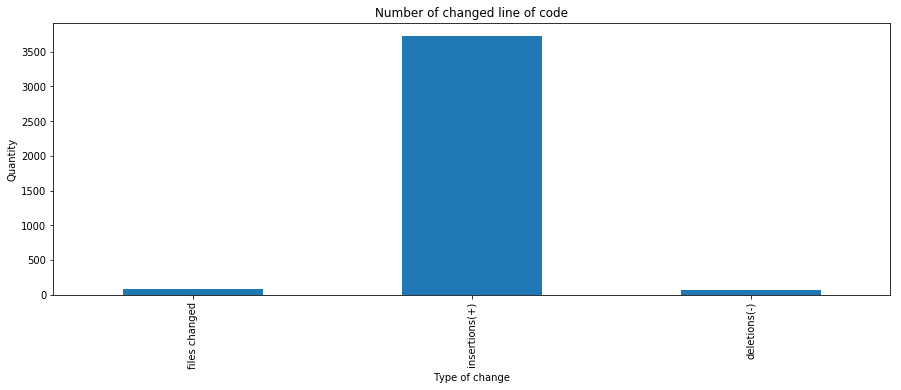

In [17]:
mygraph = data1.sum().plot(figsize=(15,5), kind='bar', title = 'Number of changed line of code')
mygraph.set_xlabel("Type of change")
mygraph.set_ylabel("Quantity")

# Applying git diff -w commitID_1 commitID2 --shortstat

In [18]:
diff = []
for i in range(0, len(com_ID)-3):
    sys.stdout.write('\rExtracting diff = %i' % (i+1) + ' out of %i' % (len(com_ID)-3))
    sys.stdout.flush()
    diff_cmd = "git diff -w " + com_ID[i+1] + " " + com_ID[i] + " --shortstat"
    diff.append(str(execute_shell_command(diff_cmd, repository)).replace("b'",'').replace("'",'').replace("\\n",' ').replace("( ",'').replace(" )",''))

Extracting diff = 58 out of 58

In [19]:
for x in range(0,len(diff)):
    line = diff[x]
    if "deletion" not in diff[x]:
        index = line.find('(+)')
        diff[x] = line[:index] + ', 0 deletions(-) ,'
    if "insertion" not in diff[x]:
        index = diff[x].find(',')
        diff[x] = line[:index] + ', 0 insertions(+)' + line[index:]
    else:
        diff[x] = diff[x]

In [20]:
diff_metrics = []
for j in range(0,len(diff)):
    diff_metrics.append(re.findall(r'\d+', diff[j]))

for k in range(0, len(diff_metrics)):
    diff_metrics[k] = list(map(int, diff_metrics[k]))

In [21]:
with open('metrics2.csv', 'w') as csvfile:
    header = ['files changed', 'insertions(+)', 'deletions(-)']
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for row in diff_metrics:
        writer.writerow(row)

In [22]:
data2 = pd.read_csv('metrics2.csv')
file_sum2 = data2['files changed'].sum()
ins_sum2 = data2['insertions(+)'].sum()
del_sum2 = data2['deletions(-)'].sum()
print ("Sum of files changed = %i" % file_sum2)
print ("Sum of insertions(+) = %i" % ins_sum2)
print ("Sum of deletions(-)  = %i" % del_sum2)
saved_column2 = data2[header]
saved_column2.head()

Sum of files changed = 80
Sum of insertions(+) = 3710
Sum of deletions(-)  = 42


files changed  insertions(+)  deletions(-)
0              8           3105             0
1              1              5             0
2              1              6             0
3              1              1             1
4              1              1             0

Text(0,0.5,'Quantity')

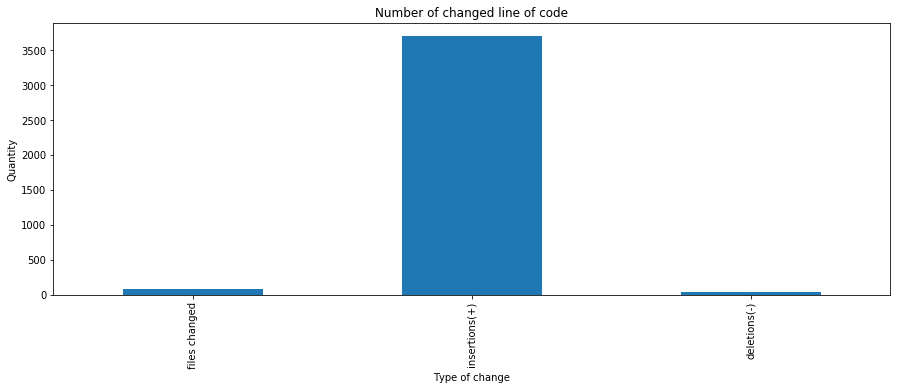

In [23]:
mygraph = data2.sum().plot(figsize=(15,5), kind='bar', title = 'Number of changed line of code')
mygraph.set_xlabel("Type of change")
mygraph.set_ylabel("Quantity")

In [24]:
data = [data1, data2]
table_sum = []
for i in range(0, len(data)):
    summ = 'command %i' % (i+1), data[i]['files changed'].sum(), data[i]['insertions(+)'].sum(), data[i]['deletions(-)'].sum()
    table_sum.append(summ)

for item in table_sum:
    print (item)

('command 1', 80, 3730, 62)
('command 2', 80, 3710, 42)


In [25]:
df = pd.DataFrame(table_sum, columns = ['command', 'files changed', 'insertions', 'deletions'])
df.to_csv('metrics_sum.csv')

In [26]:
trace1 = go.Bar(
    x=['files changed', 'insertions', 'deletions'],
    y=[file_sum1, ins_sum1, del_sum1],
    name='git diff commit1 commit2 --shortstat'
)
trace2 = go.Bar(
    x=['files changed', 'insertions', 'deletions'],
    y=[file_sum2, ins_sum2, del_sum2],
    name='git diff -w commit1 commit2 --shortstat'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

init_notebook_mode(connected=True)
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

# git diff -w --diff-algorithm=myers commit1 commit2 --shortstat

In [27]:
diff = []
for i in range(0, len(com_ID)-3):
    sys.stdout.write('\rExtracting diff = %i' % (i+1) + ' out of %i' % (len(com_ID)-3))
    sys.stdout.flush()
    diff_cmd = "git diff -w --diff-algorithm=myers " + com_ID[i+1] + " " + com_ID[i] + " --shortstat"
    diff.append(str(execute_shell_command(diff_cmd, repository)).replace("b'",'').replace("'",'').replace("\\n",' ').replace("( ",'').replace(" )",''))

Extracting diff = 58 out of 58

In [28]:
for x in range(0,len(diff)):
    line = diff[x]
    if "deletion" not in diff[x]:
        index = line.find('(+)')
        diff[x] = line[:index] + ', 0 deletions(-) ,'
    if "insertion" not in diff[x]:
        index = diff[x].find(',')
        diff[x] = line[:index] + ', 0 insertions(+)' + line[index:]
    else:
        diff[x] = diff[x]

In [ ]:
diff_metrics = []
for j in range(0,len(diff)):
    diff_metrics.append(re.findall(r'\d+', diff[j]))

for k in range(0, len(diff_metrics)):
    diff_metrics[k] = list(map(int, diff_metrics[k]))

In [ ]:
with open('metrics3.csv', 'w') as csvfile:
    header = ['files changed', 'insertions(+)', 'deletions(-)']
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for row in diff_metrics:
        writer.writerow(row)

In [ ]:
data3 = pd.read_csv('metrics3.csv')
file_sum3 = data3['files changed'].sum()
ins_sum3 = data3['insertions(+)'].sum()
del_sum3 = data3['deletions(-)'].sum()
print ("Sum of files changed = %i" % file_sum3)
print ("Sum of insertions(+) = %i" % ins_sum3)
print ("Sum of deletions(-)  = %i" % del_sum3)
saved_column3 = data3[header]
saved_column3.head()

# git diff -w --diff-algorithm=histogram commit1 commit2 --shortstat¶

In [ ]:
diff = []
for i in range(0, len(com_ID)-3):
    sys.stdout.write('\rExtracting diff = %i' % (i+1) + ' out of %i' % (len(com_ID)-3))
    sys.stdout.flush()
    diff_cmd = "git diff -w --diff-algorithm=histogram " + com_ID[i+1] + " " + com_ID[i] + " --shortstat"
    diff.append(str(execute_shell_command(diff_cmd, repository)).replace("b'",'').replace("'",'').replace("\\n",' ').replace("( ",'').replace(" )",''))

In [ ]:
for x in range(0,len(diff)):
    line = diff[x]
    if "deletion" not in diff[x]:
        index = line.find('(+)')
        diff[x] = line[:index] + ', 0 deletions(-) ,'
    if "insertion" not in diff[x]:
        index = diff[x].find(',')
        diff[x] = line[:index] + ', 0 insertions(+)' + line[index:]
    else:
        diff[x] = diff[x]

In [ ]:
diff_metrics = []
for j in range(0,len(diff)):
    diff_metrics.append(re.findall(r'\d+', diff[j]))

for k in range(0, len(diff_metrics)):
    diff_metrics[k] = list(map(int, diff_metrics[k]))

In [ ]:
with open('metrics4.csv', 'w') as csvfile:
    header = ['files changed', 'insertions(+)', 'deletions(-)']
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for row in diff_metrics:
        writer.writerow(row)

In [ ]:
data4 = pd.read_csv('metrics4.csv')
file_sum4 = data4['files changed'].sum()
ins_sum4 = data4['insertions(+)'].sum()
del_sum4 = data4['deletions(-)'].sum()
print ("Sum of files changed = %i" % file_sum4)
print ("Sum of insertions(+) = %i" % ins_sum4)
print ("Sum of deletions(-)  = %i" % del_sum4)
saved_column4 = data4[header]
saved_column4.head()

In [ ]:
trace1 = go.Bar(
    x=['files changed', 'insertions', 'deletions'],
    y=[file_sum1, ins_sum1, del_sum1],
    name='git diff'
)
trace2 = go.Bar(
    x=['files changed', 'insertions', 'deletions'],
    y=[file_sum2, ins_sum2, del_sum2],
    name='git diff -w'
)
trace3 = go.Bar(
    x=['files changed', 'insertions', 'deletions'],
    y=[file_sum3, ins_sum3, del_sum3],
    name='git diff -w --diff-algorithm=myers'
)
trace4 = go.Bar(
    x=['files changed', 'insertions', 'deletions'],
    y=[file_sum4, ins_sum4, del_sum4],
    name='git diff -w --diff-algorithm=histogram'
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group'
)

init_notebook_mode(connected=True)
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)